# Iterative TD2C Comparison with Benchmark Methods

This notebook presents a comparative analysis between an Iterative implementation of the `TD2C` method and several benchmark approaches. The `TD2C` algorithm is extended in this work through an iterative process that refines its performance by leveraging dynamic feature selection and causal graph construction.

The proposed Iterative `TD2C` method involves the following steps:

1. **Model Training and Initial Causal Discovery**: The model is initially trained, and the TD2C algorithm is applied to identify the top K causal connections.
2. **Graph Construction**: A causal graph is constructed based on the identified connections.
3. **Historical Extension**: The graph is extended to include past states, reflecting the progression from past to present.
4. **Application of Meek Rules**: The graph is refined using Meek's Rules to ensure proper orientation of edges and to derive causal implications.
5. **Missing Pair Identification and Markov Blanket Derivation**: Missing causal pairs are identified, and the Markov Blanket (MB) is derived if possible from the current graph structure.
6. **Descriptor Recalculation**: Descriptors are recalculated using the derived MB, providing refined inputs for subsequent iterations.

Through this iterative process, the TD2C method is expected to enhance its accuracy in detecting causal structures, making it a robust tool for temporal causal discovery. The effectiveness of this approach will be evaluated against benchmark methods identified from previous analyses, specifically from the `Compare_TD2C_MB_Strategies` notebook, to assess its performance improvements in terms of ROC-AUC, Precision, Recall adn F1.



# Settings

## Packages

In [4]:
import pandas as pd
from tqdm import tqdm
from multiprocessing import Pool
import pickle 
import os
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import roc_auc_score

from d2c.data_generation.builder import TSBuilder
from d2c.descriptors_generation import D2C, DataLoader
from d2c.benchmark import D2CWrapper

## Parameters setting

In [5]:
N_JOBS = 40 # number of jobs to run in parallel. For D2C, parallelism is implemented at the observation level: each observation from a single file is processed in parallel
SEED = 42 # random seed for reproducibility
MB_SIZE = 2 # size to consider when estimating the markov blanket. This is only useful if the MB is actually estimated
COUPLES_TO_CONSIDER_PER_DAG = 60 # edges that are considered in total to compute descriptors, for each TS. This can speed up the process. If set to -1, all possible edges are considered
maxlags = 5 # maximum lags to consider when considering variable couples
noise_std_filter = 0.01  # Example noise standard deviation to filter
max_neighborhood_size_filter = 2  # Example filter for neighborhood size

# Data Generation
Data are generated with the `TSBuilder` class and saved in a specific folder. Then, the code checks for missing datasets in the folder and keeps running untill all the possible combinations of parameters have genereted a dataset.

In [ ]:
# SET THE TSBUILDER WITH THE DESIRED PARAMETERS
def run_process(params):
    """
    Run a single process of the data generation.
    """
    process, n_variables, max_neighborhood_size, noise_std = params
    try:
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=42, 
                              max_attempts=200,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# BUILD THE DATA
if __name__ == '__main__':
    """
    This script generates the data for different parameters: processes, number of variables, neighborhood sizes and noise levels.
    The data is saved in the .data folder.
    The if __name__ == '__main__': is used to avoid multiprocessing issues in Jupyter notebooks, i.e. the script is run as a script and not
    as a module as it would have been if the script was imported, with the __name__ being the name of the module.
    If the script is imported, the __name__ is the name of the module, if it is run as a script, the __name__ is __main__.
    So, to run this script in a Jupyter notebook, we write the code inside the if __name__ == '__main__': block, while, if we want to import
    the functions from this script, we write "from script import run_process".
    """
    parameters = [(process, n_variables, max_neighborhood_size, noise_std)
                    for process in [1, 2, 3, 4, 6, 7, 8, 9] # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
                    for n_variables in [5] # , 10, 25
                    for max_neighborhood_size in [2] # , 4, 8
                    for noise_std in [0.01]] # , 0.005, 0.001

    with Pool(processes=N_JOBS) as pool:
        pool.map(run_process, parameters)


# Function to check for missing files
def check_missing_files():
    missing = []
    for process in [1, 2, 3, 4, 6, 7, 8, 9]:  # , 10, 11, 12, 13, 14, 15, 16, 18, 19, 20
        for n_variables in [5]:  # , 10, 25
            for max_neighborhood_size in [2]:  # , 4, 8
                for noise_std in [0.01]:  # , 0.005, 0.001
                    filename = f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl'
                    if not os.path.exists(filename):
                        missing.append(filename)
    return missing

# Function to run the process
def run_process(params):
    process, n_variables, max_neighborhood_size, noise_std = params
    try:  # we change the seed and increase the max_attempts
        tsbuilder = TSBuilder(observations_per_time_series=250, 
                              maxlags=5, 
                              n_variables=n_variables, 
                              time_series_per_process=40, 
                              processes_to_use=[process], 
                              noise_std=noise_std, 
                              max_neighborhood_size=max_neighborhood_size, 
                              seed=24, 
                              max_attempts=400,
                              verbose=True)

        tsbuilder.build()
        tsbuilder.to_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}.pkl')
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} done')
    except ValueError as e:
        print(f'P{process}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std} failed: {e}')

# CHECK FOR MISSING FILES (IT CHEKS THE FILES WITH A DIFFERENT SEED AND MORE MAX_ATTEMPTS UNTILL MISSING IS EMPTY)
if __name__ == '__main__':
    while True:
        missing = check_missing_files()
        if not missing:
            break

        parameters = []
        for missing_file in missing:
            process = int(missing_file.split('/')[-1].split('_')[0][1:])
            n_variables = int(missing_file.split('/')[-1].split('_')[1][1:])
            max_neighborhood_size = int(missing_file.split('/')[-1].split('_')[2][2:])
            noise_std = float(missing_file.split('/')[-1].split('_')[3][1:-4])
            parameters.append((process, n_variables, max_neighborhood_size, noise_std))

        with Pool(processes=N_JOBS) as pool:
            pool.map(run_process, parameters)

len(os.listdir('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data'))


# Descriptors Generation & Classification

## Regression Estimation of MI

### D2C (& D2C but without contemporaneous nodes) 

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    D2C_rocs_process, D2C_precision_process, D2C_recall_process, D2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(D2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process, TD2C_precision_process, TD2C_recall_process, TD2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (All methods)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################

# SET FOLDER
cartella = 8
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3, 
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with one variable from ranking
# 6 = TD2C_+Ranking_5 with one variable from ranking
# 7 = TD2C_+Ranking_6 with one variable from ranking
# 8 = TD2C_+Ranking_7 with one variable from ranking

if cartella == 1:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    ts_rank = 'ts_rank'
    vars_to_keep = 1
elif cartella == 11:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 2
elif cartella == 111:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 3
elif cartella == 110:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 10
elif cartella == 2:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    ts_rank = 'ts_rank_2'
    vars_to_keep = 1
elif cartella == 3:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    ts_rank = 'ts_rank_3'
    vars_to_keep = 1
elif cartella == 4:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    ts_rank = 'ts_rank_no_cont' 
    vars_to_keep = 1
elif cartella == 5:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    ts_rank = 'ts_rank_4' 
    vars_to_keep = 1
elif cartella == 6:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    ts_rank = 'ts_rank_5' 
    vars_to_keep = 1
elif cartella == 7:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_6/'
    ts_rank = 'ts_rank_6' 
    vars_to_keep = 1
elif cartella == 8:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_7/'
    ts_rank = 'ts_rank_7' 
    vars_to_keep = 1

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= ts_rank,
            top_vars = vars_to_keep)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []

# TAKES THE FOLDER SET AT THE STEP BEFORE AND RUN ALL THE FOLLOWING CELLS FOR THIS METHOD
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with two variables from ranking
# 6 = TD2C_+Ranking_5 with three variables from ranking

if cartella == 1:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_2/'
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C_+Ranking_3/'
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_4/'
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_5/'
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_6/'
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_+Ranking/TD2C+Ranking_7/'
    name = 'TD2C_Ranking_7'



# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file


for n_vars, todo in todos.items():
    m1 = f'{name}_rocs_process'
    m2 = f'{name}_precision_process'
    m3 = f'{name}_recall_process'
    m4 = f'{name}_f1_process'

    globals()[m1] = {}
    globals()[m2] = {}
    globals()[m3] = {}
    globals()[m4] = {}


    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        globals()[m1][gen_process_number] = rocs
        globals()[m2][gen_process_number] = precisions
        globals()[m3][gen_process_number] = recalls
        globals()[m4][gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_{name}_N5.pkl'), 'wb') as f:
    everything = (globals()[m1], globals()[m2], globals()[m3], globals()[m4])
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Load data for local and global plots

##### local save

In [ ]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# LOCAL
with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
    globals()[m1], globals()[m2], globals()[m3], globals()[m4] = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

##### global save

In [ ]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

cartella = 8

if cartella == 1:
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    name = 'TD2C_Ranking_7'

if cartella == 1:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_1_Var_rocs_process, TD2C_Ranking_1_1_Var_precision_process, TD2C_Ranking_1_1_Var_recall_process, TD2C_Ranking_1_1_Var_f1_process = pickle.load(f)
elif cartella == 11:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_2_Var_rocs_process, TD2C_Ranking_1_2_Var_precision_process, TD2C_Ranking_1_2_Var_recall_process, TD2C_Ranking_1_2_Var_f1_process = pickle.load(f)
elif cartella == 111:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_3_Var_rocs_process, TD2C_Ranking_1_3_Var_precision_process, TD2C_Ranking_1_3_Var_recall_process, TD2C_Ranking_1_3_Var_f1_process = pickle.load(f)
elif cartella == 110:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_10_Var_rocs_process, TD2C_Ranking_1_10_Var_precision_process, TD2C_Ranking_1_10_Var_recall_process, TD2C_Ranking_1_10_Var_f1_process = pickle.load(f)
elif cartella == 2:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_2_rocs_process, TD2C_Ranking_2_precision_process, TD2C_Ranking_2_recall_process, TD2C_Ranking_2_f1_process = pickle.load(f)
elif cartella == 3:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_3_rocs_process, TD2C_Ranking_3_precision_process, TD2C_Ranking_3_recall_process, TD2C_Ranking_3_f1_process = pickle.load(f)
elif cartella == 4:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_NoCont_rocs_process, TD2C_Ranking_NoCont_precision_process, TD2C_Ranking_NoCont_recall_process, TD2C_Ranking_NoCont_f1_process = pickle.load(f)
elif cartella == 5:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_4_rocs_process, TD2C_Ranking_4_precision_process, TD2C_Ranking_4_recall_process, TD2C_Ranking_4_f1_process = pickle.load(f)
elif cartella == 6:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_5_rocs_process, TD2C_Ranking_5_precision_process, TD2C_Ranking_5_recall_process, TD2C_Ranking_5_f1_process = pickle.load(f)
elif cartella == 7:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_6_rocs_process, TD2C_Ranking_6_precision_process, TD2C_Ranking_6_recall_process, TD2C_Ranking_6_f1_process = pickle.load(f)
elif cartella == 8:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_7_rocs_process, TD2C_Ranking_7_precision_process, TD2C_Ranking_7_recall_process, TD2C_Ranking_7_f1_process = pickle.load(f)

#### Plot

In [ ]:
df1 = pd.DataFrame(globals()[m1])
df_name = f'{name}_rocs_dataset'
globals()[df_name] = df1

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} {name}')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for {name} method, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C_PastFut/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_rocs_process = {}
    td2c_past_precision_process = {}
    td2c_past_recall_process = {}
    td2c_past_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_rocs_process[gen_process_number] = rocs
        td2c_past_precision_process[gen_process_number] = precisions
        td2c_past_recall_process[gen_process_number] = recalls
        td2c_past_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_rocs_process, td2c_past_precision_process, td2c_past_recall_process, td2c_past_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    TD2C_Ranking_PastFut_rocs_process, TD2C_Ranking_PastFut_precision_process, TD2C_Ranking_PastFut_recall_process, TD2C_Ranking_PastFut_f1_process = pickle.load(f) 

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

## KNNCMI Estimation of MI

### D2C (& D2C but without contemporaneous nodes) 

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'original',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/D2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    d2c_rocs_process = {}
    d2c_precision_process = {}
    d2c_recall_process = {}
    d2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        d2c_rocs_process[gen_process_number] = rocs
        d2c_precision_process[gen_process_number] = precisions
        d2c_recall_process[gen_process_number] = recalls
        d2c_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_d2c_R_N5.pkl'), 'wb') as f:
    everything = (d2c_rocs_process, d2c_precision_process, d2c_recall_process, d2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

with open(os.path.join(input_folder, 'journal_results_d2c_R_N5.pkl'), 'rb') as f:
    D2C_rocs_process, D2C_precision_process, D2C_recall_process, D2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(D2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} D2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for D2C method with KnnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C (& TD2C but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts',
            top_vars=3)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N10.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_td2c_R_N25.pkl'), 'wb') as f:
#     everything = (td2c_R_rocs_process, td2c_R_precision_process, td2c_R_recall_process, td2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process, TD2C_precision_process, TD2C_recall_process, TD2C_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method, with KnnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C + Ranking (All methods)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################

# SET FOLDER
cartella = 8
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3, 
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with one variable from ranking
# 6 = TD2C_+Ranking_5 with one variable from ranking
# 7 = TD2C_+Ranking_6 with one variable from ranking
# 8 = TD2C_+Ranking_7 with one variable from ranking

if cartella == 1:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    ts_rank = 'ts_rank'
    vars_to_keep = 1
elif cartella == 11:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 2
elif cartella == 111:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 3
elif cartella == 110:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    ts_rank = 'ts_rank'
    vars_to_keep = 10
elif cartella == 2:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_2/'
    ts_rank = 'ts_rank_2'
    vars_to_keep = 1
elif cartella == 3:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_3/'
    ts_rank = 'ts_rank_3'
    vars_to_keep = 1
elif cartella == 4:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    ts_rank = 'ts_rank_no_cont' 
    vars_to_keep = 1
elif cartella == 5:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_4/'
    ts_rank = 'ts_rank_4' 
    vars_to_keep = 1
elif cartella == 6:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_5/'
    ts_rank = 'ts_rank_5' 
    vars_to_keep = 1
elif cartella == 7:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_6/'
    ts_rank = 'ts_rank_6' 
    vars_to_keep = 1
elif cartella == 8:
    output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_7/'
    ts_rank = 'ts_rank_7' 
    vars_to_keep = 1

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= ts_rank,
            top_vars = vars_to_keep)

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []

# TAKES THE FOLDER SET AT THE STEP BEFORE AND RUN ALL THE FOLLOWING CELLS FOR THIS METHOD
# 1 = TD2C_+Ranking_1
# 2 = TD2C_+Ranking_2
# 3 = TD2C_+Ranking_3
# 4 = TD2C_+Ranking_NoCont
# 11 = TD2C_+Ranking_1 with two variables from ranking 
# 111 = TD2C_+Ranking_1 with three variables from ranking
# 110 = TD2C_+Ranking_1 with ten variables from ranking
# 5 = TD2C_+Ranking_4 with two variables from ranking
# 6 = TD2C_+Ranking_5 with three variables from ranking

if cartella == 1:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/1_Var/' 
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/2_Var/'
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/3_Var/'
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_1/10_Var/'
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_2/'
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C_+Ranking_3/'
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_NoCont/'
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_4/'
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_5/'
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_6/'
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_+Ranking/TD2C+Ranking_7/'
    name = 'TD2C_Ranking_7'



# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file


for n_vars, todo in todos.items():
    m1 = f'{name}_rocs_process'
    m2 = f'{name}_precision_process'
    m3 = f'{name}_recall_process'
    m4 = f'{name}_f1_process'

    globals()[m1] = {}
    globals()[m2] = {}
    globals()[m3] = {}
    globals()[m4] = {}


    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        globals()[m1][gen_process_number] = rocs
        globals()[m2][gen_process_number] = precisions
        globals()[m3][gen_process_number] = recalls
        globals()[m4][gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_{name}_N5.pkl'), 'wb') as f:
    everything = (globals()[m1], globals()[m2], globals()[m3], globals()[m4])
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Load data for local and global plots

##### local save

In [ ]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

# LOCAL
with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
    globals()[m1], globals()[m2], globals()[m3], globals()[m4] = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

##### global save

In [ ]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

cartella = 8

if cartella == 1:
    name = 'TD2C_Ranking_1_1_Var'
elif cartella == 11:
    name = 'TD2C_Ranking_1_2_Var'
elif cartella == 111:
    name = 'TD2C_Ranking_1_3_Var'
elif cartella == 110:
    name = 'TD2C_Ranking_1_10_Var'
elif cartella == 2:
    name = 'TD2C_Ranking_2'
elif cartella == 3:
    name = 'TD2C_Ranking_3'
elif cartella == 4:
    name = 'TD2C_Ranking_NoCont'
elif cartella == 5:
    name = 'TD2C_Ranking_4'
elif cartella == 6:
    name = 'TD2C_Ranking_5'
elif cartella == 7:
    name = 'TD2C_Ranking_6'
elif cartella == 8:
    name = 'TD2C_Ranking_7'

if cartella == 1:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_1_Var_rocs_process, TD2C_Ranking_1_1_Var_precision_process, TD2C_Ranking_1_1_Var_recall_process, TD2C_Ranking_1_1_Var_f1_process = pickle.load(f)
elif cartella == 11:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_2_Var_rocs_process, TD2C_Ranking_1_2_Var_precision_process, TD2C_Ranking_1_2_Var_recall_process, TD2C_Ranking_1_2_Var_f1_process = pickle.load(f)
elif cartella == 111:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_3_Var_rocs_process, TD2C_Ranking_1_3_Var_precision_process, TD2C_Ranking_1_3_Var_recall_process, TD2C_Ranking_1_3_Var_f1_process = pickle.load(f)
elif cartella == 110:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_1_10_Var_rocs_process, TD2C_Ranking_1_10_Var_precision_process, TD2C_Ranking_1_10_Var_recall_process, TD2C_Ranking_1_10_Var_f1_process = pickle.load(f)
elif cartella == 2:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_2_rocs_process, TD2C_Ranking_2_precision_process, TD2C_Ranking_2_recall_process, TD2C_Ranking_2_f1_process = pickle.load(f)
elif cartella == 3:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_3_rocs_process, TD2C_Ranking_3_precision_process, TD2C_Ranking_3_recall_process, TD2C_Ranking_3_f1_process = pickle.load(f)
elif cartella == 4:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_NoCont_rocs_process, TD2C_Ranking_NoCont_precision_process, TD2C_Ranking_NoCont_recall_process, TD2C_Ranking_NoCont_f1_process = pickle.load(f)
elif cartella == 5:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_4_rocs_process, TD2C_Ranking_4_precision_process, TD2C_Ranking_4_recall_process, TD2C_Ranking_4_f1_process = pickle.load(f)
elif cartella == 6:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_5_rocs_process, TD2C_Ranking_5_precision_process, TD2C_Ranking_5_recall_process, TD2C_Ranking_5_f1_process = pickle.load(f)
elif cartella == 7:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_6_rocs_process, TD2C_Ranking_6_precision_process, TD2C_Ranking_6_recall_process, TD2C_Ranking_6_f1_process = pickle.load(f)
elif cartella == 8:
    with open(os.path.join(input_folder, f'journal_results_{name}_N5.pkl'), 'rb') as f:
        TD2C_Ranking_7_rocs_process, TD2C_Ranking_7_precision_process, TD2C_Ranking_7_recall_process, TD2C_Ranking_7_f1_process = pickle.load(f)

#### Plot

In [ ]:
df1 = pd.DataFrame(globals()[m1])
df_name = f'{name}_rocs_dataset'
globals()[df_name] = df1

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} {name}')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title(f'Boxplot of ROC-AUC scores for {name} method, with KnnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

### TD2C in the past-future (& TD2C in the past-future but without contrmporaneous nodes)

#### Descriptors Generation

In [ ]:
######################################################### SETTING FOR DESCRIPTORS COMPUTATION ######################################################

input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_process = [] # list of files to process

# This loop is used to filter the files to process and obtain the parameters of the process
# The resulting list will be used to parallelize the process and will be passed to the DataLoader.
# The result is of the form (file, gen_process_number, n_variables, max_neighborhood_size, noise_std)
# asnd is saved in the to_process list.
for file in sorted(os.listdir(input_folder)): 
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != 0.01:
        continue
    
    if max_neighborhood_size != 2:
        continue

    # if n_variables != 5:
    #     continue

    to_process.append(file)


############################################################### COMPUTE DESCRIPTORS ################################################################
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_PastFut/'  

# create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# This loop processes the files in the input folder (to_process) and saves the descriptors in the output folder.

# At first, we collect the parameters of the process from the file name.
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=dataloader.get_dags(), 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='cmiknn_3',
            mb_estimator= 'ts_past')

    d2c.initialize() # initializes the D2C object

    descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    # The descriptors are saved in the output folder as a pickle file.
    descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

#### Run Classifier

In [ ]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/KnnCMI/TD2C_PastFut/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics

In [ ]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_past_rocs_process = {}
    td2c_past_precision_process = {}
    td2c_past_recall_process = {}
    td2c_past_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_past_rocs_process[gen_process_number] = rocs
        td2c_past_precision_process[gen_process_number] = precisions
        td2c_past_recall_process[gen_process_number] = recalls
        td2c_past_f1_process[gen_process_number] = f1s

#### Save Results

In [ ]:
# pickle everything
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_past_R_N5.pkl'), 'wb') as f:
    everything = (td2c_past_rocs_process, td2c_past_precision_process, td2c_past_recall_process, td2c_past_f1_process)
    pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N10.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)

# with open(os.path.join(output_folder, f'journal_results_d2c_R_N25.pkl'), 'wb') as f:
#     everything = (d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process)
#     pickle.dump(everything, f)  

#### Plot

In [ ]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/KnnCMI/journals/'

with open(os.path.join(input_folder, 'journal_results_td2c_past_R_N5.pkl'), 'rb') as f:
    TD2C_Ranking_PastFut_rocs_process, TD2C_Ranking_PastFut_precision_process, TD2C_Ranking_PastFut_recall_process, TD2C_Ranking_PastFut_f1_process = pickle.load(f) 

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N10.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)

# with open(os.path.join(input_folder, 'journal_results_d2c_R_N25.pkl'), 'rb') as f:
#     d2c_R_rocs_process, d2c_R_precision_process, d2c_R_recall_process, d2c_R_f1_process = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Past_Reg')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])


plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C_Past method with KnnCMI to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

# Iterative TD2C implementation

#### some tries

In [ ]:
# extracting the causal paths from the descriptors files for each process

proc = [1,2,3,4,6,7,8,9,10,11,12,13,14,15,16,18,19,20]
td2c_descriptors = {}
for i in proc:
    td2c_desc = pd.read_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/P{i}_N5_Nj2_n0.01_MB2.pkl')
    td2c_causal_paths = td2c_desc.loc[td2c_desc['is_causal'] == 1]
    td2c_causal_paths = td2c_causal_paths.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True)
    td2c_causal_paths = td2c_causal_paths[['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest']]
    # make unique the edge_source and edge_dest combinations
    td2c_causal_paths = td2c_causal_paths.drop_duplicates(subset=['edge_source', 'edge_dest'])
    td2c_descriptors[i] = td2c_causal_paths

td2c_descriptors[1]


In [ ]:
# plotting the graph for each process

import networkx as nx

# create a graph for each process
for i in proc:
    # get the descriptors for the process
    td2c_causal_paths = td2c_descriptors[i]

    # create a graph
    G = nx.DiGraph()
    G.add_edges_from(td2c_causal_paths[['edge_source', 'edge_dest']].values)

# plot the graph
plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True, node_size=1000, node_color='skyblue', font_size=10, font_weight='bold', font_color='black', edge_color='gray', pos=nx.spring_layout(G))
plt.title(f'Graph for process {i}')
plt.show()

In [ ]:
# creating a graph for each process

# Define the list of processes to handle
proc = [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20]
td2c_descriptors = {}

# Iterate through each process ID and process the corresponding pickle file
for i in proc:
    # Load the pickle file containing the data
    td2c_desc = pd.read_pickle(f'/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/P{i}_N5_Nj2_n0.01_MB2.pkl')
    
    # Filter rows where 'is_causal' is 1, indicating a causal relationship
    td2c_causal_paths = td2c_desc.loc[td2c_desc['is_causal'] == 1]
    
    # Sort by 'edge_source' and 'edge_dest' to organize the causal paths
    td2c_causal_paths = td2c_causal_paths.sort_values(by=['edge_source', 'edge_dest']).reset_index(drop=True)
    
    # Select relevant columns
    td2c_causal_paths = td2c_causal_paths[['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size', 'noise_std', 'edge_source', 'edge_dest']]
    
    # Remove duplicate causal paths based on 'edge_source' and 'edge_dest' combinations
    td2c_causal_paths = td2c_causal_paths.drop_duplicates(subset=['edge_source', 'edge_dest'])
    
    # Store the processed DataFrame in a dictionary keyed by the process ID
    td2c_descriptors[i] = td2c_causal_paths

# Example to view the causal paths for process 1
# print(td2c_descriptors[1])

# Initialize a dictionary to store the DAGs for each process
dags = {}

for process_id, df in td2c_descriptors.items():
    dags[process_id] = {}
    unique_graph_ids = df['graph_id'].unique()
    
    for graph_id in unique_graph_ids:
        # Filter the DataFrame for the current graph_id
        df_graph = df[df['graph_id'] == graph_id]
        
        # Initialize an empty directed graph
        G = nx.DiGraph()
        
        # Add nodes
        for j in range(df_graph['n_variables'].iloc[0]):
            G.add_node(j)
        
        # Add edges based on causal relationships
        for _, row in df_graph.iterrows():
            G.add_edge(row['edge_source'], row['edge_dest'])
        
        # Store the graph in the dictionary
        dags[process_id][graph_id] = G

# Example to access and view the nodes and edges of the graph for process_id 1, graph_id 0
dags[1][0].nodes, dags[1][0].edges


### second try

#### Descriptors Generation (first estimation)

In [45]:
import os
import pandas as pd
import networkx as nx
from tqdm import tqdm

# Setting parameters for the process
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/initial/'
DAGs_2 = {}

# List of files to process
to_process = []

# Filtering the files to process
for file in sorted(os.listdir(input_folder)):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    if noise_std != noise_std_filter or max_neighborhood_size != max_neighborhood_size_filter:
        continue

    to_process.append(file)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Process each file and create new DAGs based on causal paths
for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

    dataloader = DataLoader(n_variables=n_variables, maxlags=maxlags)
    dataloader.from_pickle(input_folder + file)

    d2c = D2C(
        observations=dataloader.get_observations(),
        dags=dataloader.get_dags(),
        couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG,
        MB_size=MB_SIZE,
        n_variables=n_variables,
        maxlags=maxlags,
        seed=SEED,
        n_jobs=N_JOBS,
        full=True,
        quantiles=True,
        normalize=True,
        cmi='original',
        mb_estimator='ts',
        top_vars=3
    )

    d2c.initialize()  # Initializes the D2C object
    descriptors_df = d2c.get_descriptors_df()  # Computes the descriptors

    # Extract causal paths to create new DAGs
    new_dags = []
    for dag in dataloader.get_dags():
        new_dag = nx.DiGraph()  # Create a new directed graph
        for index, row in descriptors_df.iterrows():
            if row['is_causal'] == 1:
                source = row['edge_source']
                effect = row['edge_dest']
                new_dag.add_edge(source, effect)  # Add causal relationships
        new_dags.append(new_dag)

    # Replace the original DAGs with new DAGs
    # This assumes you want to use the new DAGs for further processing
    # d2c.dags = new_dags  # Update DAGs in D2C object

    # Save the new DAGs in the dictionary
    DAGs_2[gen_process_number] = new_dags

    # Save the descriptors along with new DAGs if needed
    descriptors_df.insert(0, 'process_id', gen_process_number)
    descriptors_df.insert(2, 'n_variables', n_variables)
    descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
    descriptors_df.insert(4, 'noise_std', noise_std)

    descriptors_df.to_pickle(output_folder + f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

    # Run further estimation processes using the new DAGs as needed
    # Example: d2c.run_estimation() # Call the estimation method if available

100%|██████████| 18/18 [02:20<00:00,  7.78s/it]


In [46]:
old_dags = dataloader.get_dags()
old_dags[0].nodes, old_dags[0].edges

(NodeView((25, 26, 27, 28, 29, 20, 21, 22, 23, 24, 15, 16, 17, 18, 19, 10, 11, 12, 13, 14, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4)),
 OutEdgeView([(25, 20), (25, 22), (25, 15), (25, 17), (26, 21), (26, 16), (27, 20), (27, 22), (27, 15), (27, 17), (28, 23), (28, 18), (29, 21), (29, 24), (29, 16), (29, 19), (20, 15), (20, 17), (20, 10), (20, 12), (21, 16), (21, 11), (22, 15), (22, 17), (22, 10), (22, 12), (23, 18), (23, 13), (24, 16), (24, 19), (24, 11), (24, 14), (15, 10), (15, 12), (15, 5), (15, 7), (16, 11), (16, 6), (17, 10), (17, 12), (17, 5), (17, 7), (18, 13), (18, 8), (19, 11), (19, 14), (19, 6), (19, 9), (10, 5), (10, 7), (10, 0), (10, 2), (11, 6), (11, 1), (12, 5), (12, 7), (12, 0), (12, 2), (13, 8), (13, 3), (14, 6), (14, 9), (14, 1), (14, 4), (5, 0), (5, 2), (6, 1), (7, 0), (7, 2), (8, 3), (9, 1), (9, 4)]))

#### Descriptors Generation (second estimation)

In [48]:
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/second_estimate/'

for file in tqdm(to_process):
    gen_process_number = int(file.split('_')[0][1:])
    n_variables = int(file.split('_')[1][1:])
    max_neighborhood_size = int(file.split('_')[2][2:])
    noise_std = float(file.split('_')[3][1:-4])

# The DataLoader is initialized with the parameters of the process. 
    dataloader = DataLoader(n_variables = n_variables,
                    maxlags = maxlags)
    dataloader.from_pickle(input_folder+file)

# The D2C object is initialized with the DataLoader and the parameters of the process.
    d2c = D2C(observations=dataloader.get_observations(), 
            dags=DAGs_2[gen_process_number], 
            couples_to_consider_per_dag=COUPLES_TO_CONSIDER_PER_DAG, 
            MB_size=MB_SIZE, 
            n_variables=n_variables, 
            maxlags=maxlags,
            seed=SEED,
            n_jobs=N_JOBS,
            full=True,
            quantiles=True,
            normalize=True,
            cmi='original',
            mb_estimator= 'ts',
            top_vars=3)

d2c.initialize() # initializes the D2C object

descriptors_df = d2c.get_descriptors_df()  # computes the descriptors

descriptors_df.insert(0, 'process_id', gen_process_number)
descriptors_df.insert(2, 'n_variables', n_variables)
descriptors_df.insert(3, 'max_neighborhood_size', max_neighborhood_size)
descriptors_df.insert(4, 'noise_std', noise_std)

# The descriptors are saved in the output folder as a pickle file.
descriptors_df.to_pickle(output_folder+f'P{gen_process_number}_N{n_variables}_Nj{max_neighborhood_size}_n{noise_std}_MB{MB_SIZE}.pkl')

100%|██████████| 18/18 [00:00<00:00, 149.04it/s]


#### Run Classifier (initial estimate)

In [49]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos = {'5': to_dos_5_variables} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs = []
descriptors_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/initial/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs.append(df)

# we concatenate the descriptors
descriptors_training = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Run Classifier (second estimate)

In [50]:
data_root = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/data/to_use/'

to_dos_2 = []

# This loop gets a list of all the files to be processed
for testing_file in sorted(os.listdir(data_root)):
    if testing_file.endswith('.pkl'):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])
          
        if noise_std != 0.01: # if the noise is different we skip the file
            continue

        if max_neighborhood_size != 2: # if the max_neighborhood_size is different we skip the file
            continue

        to_dos_2.append(testing_file) # we add the file to the list (to_dos) to be processed

# sort to_dos by number of variables
to_dos_5_variables_2 = [file for file in to_dos_2 if int(file.split('_')[1][1:]) == 5]
# to_dos_10_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 10]
# to_dos_25_variables = [file for file in to_dos if int(file.split('_')[1][1:]) == 25]

# we create a dictionary with the lists of files to be processed
todos_2 = {'5': to_dos_5_variables_2} # , '10': to_dos_10_variables, '25': to_dos_25_variables

# we create a dictionary to store the results
dfs_2 = []
descriptors_root_2 = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/descriptors/Regression/TD2C/iterative/second_estimate/'

# Re-save pickle files with protocol 4
for testing_file in sorted(os.listdir(descriptors_root_2)):
    if testing_file.endswith('.pkl'):
        file_path = os.path.join(descriptors_root_2, testing_file)
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        
        # Re-save with protocol 4
        with open(file_path, 'wb') as f:
            pickle.dump(data, f, protocol=4)

# This loop gets the descriptors for the files to be processed
for testing_file in sorted(os.listdir(descriptors_root_2)):
    if testing_file.endswith('.pkl'):
        df = pd.read_pickle(os.path.join(descriptors_root_2, testing_file))
        if isinstance(df, pd.DataFrame):
            dfs_2.append(df)

# we concatenate the descriptors
descriptors_training_2 = pd.concat(dfs, axis=0).reset_index(drop=True)

#### Evaluation Metrics (initial estimation)

In [51]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos.items():
    td2c_rocs_process = {}
    td2c_precision_process = {}
    td2c_recall_process = {}
    td2c_f1_process = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training.loc[descriptors_training['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training.loc[(descriptors_training['process_id'] == gen_process_number) & (descriptors_training['n_variables'] == n_variables) & (descriptors_training['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process[gen_process_number] = rocs
        td2c_precision_process[gen_process_number] = precisions
        td2c_recall_process[gen_process_number] = recalls
        td2c_f1_process[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Evaluation Metrics (second estimation)

In [55]:
# This loop does the following:
# 1. Creates some dictionaries to store the results
# 2. Loads the training data
# 3. Trains the model
# 4. Evaluates the model
# 5. Stores the results in the dictionaries
# 6. Saves the dictionaries in a pickle file

for n_vars, todo in todos_2.items():
    td2c_rocs_process_2 = {}
    td2c_precision_process_2 = {}
    td2c_recall_process_2 = {}
    td2c_f1_process_2 = {}
    for testing_file in tqdm(todo):
        gen_process_number = int(testing_file.split('_')[0][1:])
        n_variables = int(testing_file.split('_')[1][1:])
        max_neighborhood_size = int(testing_file.split('_')[2][2:])
        noise_std = float(testing_file.split('_')[3][1:-4])

        # split training and testing data
        training_data = descriptors_training_2.loc[descriptors_training_2['process_id'] != gen_process_number]
        X_train = training_data.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
        y_train = training_data['is_causal']

        testing_data = descriptors_training_2.loc[(descriptors_training_2['process_id'] == gen_process_number) & (descriptors_training_2['n_variables'] == n_variables) & (descriptors_training_2['max_neighborhood_size'] == max_neighborhood_size) & (descriptors_training_2['noise_std'] == noise_std)]

        model = BalancedRandomForestClassifier(n_estimators=100, random_state=0, n_jobs=50, max_depth=None, sampling_strategy='auto', replacement=True, bootstrap=False)
        # model = RandomForestClassifier(n_estimators=50, random_state=0, n_jobs=50, max_depth=10)

        model.fit(X_train, y_train)

        rocs = {}
        precisions = {}
        recalls = {}
        f1s = {}
        for graph_id in range(40):
            #load testing descriptors
            test_df = testing_data.loc[testing_data['graph_id'] == graph_id]
            test_df = test_df.sort_values(by=['edge_source','edge_dest']).reset_index(drop=True) # sort for coherence

            X_test = test_df.drop(columns=['process_id', 'graph_id', 'n_variables', 'max_neighborhood_size','noise_std', 'edge_source', 'edge_dest', 'is_causal',])
            y_test = test_df['is_causal']

            y_pred_proba = model.predict_proba(X_test)[:,1]
            y_pred = model.predict(X_test)

            roc = roc_auc_score(y_test, y_pred_proba)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            
            rocs[graph_id] = roc
            precisions[graph_id] = precision
            recalls[graph_id] = recall
            f1s[graph_id] = f1

        td2c_rocs_process_2[gen_process_number] = rocs
        td2c_precision_process_2[gen_process_number] = precisions
        td2c_recall_process_2[gen_process_number] = recalls
        td2c_f1_process_2[gen_process_number] = f1s

  0%|          | 0/18 [00:00<?, ?it/s]/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/myenv3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jpalombarini/td2c/my

#### Save Results

In [58]:
# pickle everything initial estimation
output_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

with open(os.path.join(output_folder, f'journal_results_td2c_R_N5.pkl'), 'wb') as f:
    everything = (td2c_rocs_process, td2c_precision_process, td2c_recall_process, td2c_f1_process)
    pickle.dump(everything, f)


# pickle everything second estimation
output_folder_2 = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'

# Create the folder if it doesn't exist
if not os.path.exists(output_folder_2):
    os.makedirs(output_folder_2)

with open(os.path.join(output_folder_2, f'journal_results_td2c_R_N5_2.pkl'), 'wb') as f:
    everything_2 = (td2c_rocs_process_2, td2c_precision_process_2, td2c_recall_process_2, td2c_f1_process_2)
    pickle.dump(everything_2, f)

#### Plot

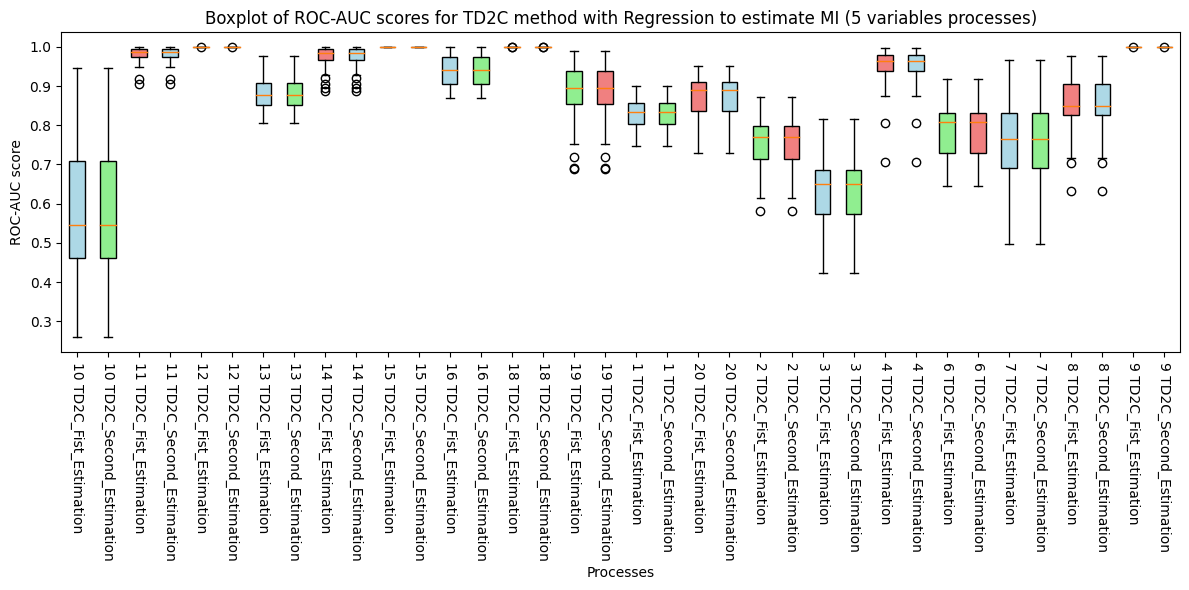

In [59]:
#################################################################### LOAD DATA #####################################################################
input_folder = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/initial/'
input_folder_2 = '/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/journals/iterative/second_estimation/'


with open(os.path.join(input_folder, 'journal_results_td2c_R_N5.pkl'), 'rb') as f:
    TD2C_rocs_process, TD2C_precision_process, TD2C_recall_process, TD2C_f1_process = pickle.load(f)

with open(os.path.join(input_folder_2, 'journal_results_td2c_R_N5_2.pkl'), 'rb') as f:
    TD2C_rocs_process_2, TD2C_precision_process_2, TD2C_recall_process_2, TD2C_f1_process_2 = pickle.load(f)


##################################################################### PLOT #########################################################################

df1 = pd.DataFrame(TD2C_rocs_process)

df2 = pd.DataFrame(TD2C_rocs_process_2)

# Combine data for boxplot
combined_data = []

for col in df1.columns:
    combined_data.append(df1[col])
    combined_data.append(df2[col])

# Create labels for x-axis
labels = []
for col in df1.columns:
    labels.append(f'{col} TD2C_Fist_Estimation')
    labels.append(f'{col} TD2C_Second_Estimation')

# Plotting
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplot of ROC-AUC scores for TD2C method with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('ROC-AUC score')
plt.tight_layout()
plt.show()

In [14]:
df1.mean().mean(), df2.mean().mean()

(0.8718456306219083, 0.8718456306219083)

# Plot all Results - Comparison

## Regression for MI estimation

### ROC-AUC

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplots ROC-AUC scores per process for TD2C methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Boxplots ROC-AUC scores per process for TD2C methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocouc_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean ROC-AUC score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='roc_auc')

df['roc_auc'] = df['roc_auc'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='roc_auc')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_rocs_process': 'TD2C_+Ranking_1_1_Var_rocs_process', 
                        'TD2C_+Ranking_1_2_Var_rocs_process': 'TD2C_+Ranking_1_2_Var_rocs_process', 
                        # 'TD2C_+Ranking_1_3_Var_rocs_process': 'TD2C_+Ranking_1_3_Var_rocs_process',
                        # 'TD2C_+Ranking_1_10_Var_rocs_process': 'TD2C_+Ranking_1_10_Var_rocs_process', 
                        'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process', 
                        'TD2C_+Ranking_3_rocs_process': 'TD2C_+Ranking_3_rocs_process',
                        'TD2C_+Ranking_4_rocs_process': 'TD2C_+Ranking_4_rocs_process', 
                        'TD2C_+Ranking_NoCont_rocs_process': 'TD2C_+Ranking_NoCont_rocs_process',
                        'TD2C_R_rocs_process': 'TD2C_R_rocs_process',
                        'TD2C_+Ranking_PastFut_rocs_process': 'TD2C_+Ranking_PastFut_rocs_process',
                        'D2C_R_rocs_process': 'D2C_R_rocs_process'})

# eliminate the column method and make the process_id the index of the dataframe



# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'roc_auc'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean ROC-AUC scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'roc_auc'})

df = df.sort_values(by='roc_auc', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['roc_auc'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Precision

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Precision score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Precision')

df['Precision'] = df['Precision'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Precision')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_precision_process': 'TD2C_+Ranking_1_1_Var_precision_process',
                        'TD2C_+Ranking_1_2_Var_precision_process': 'TD2C_+Ranking_1_2_Var_precision_process',
                        # 'TD2C_+Ranking_1_3_Var_precision_process': 'TD2C_+Ranking_1_3_Var_precision_process',
                        # 'TD2C_+Ranking_1_10_Var_precision_process': 'TD2C_+Ranking_1_10_Var_precision_process',
                        'TD2C_+Ranking_2_precision_process': 'TD2C_+Ranking_2_precision_process',
                        'TD2C_+Ranking_3_precision_process': 'TD2C_+Ranking_3_precision_process',
                        'TD2C_+Ranking_4_precision_process': 'TD2C_+Ranking_4_precision_process',
                        'TD2C_+Ranking_NoCont_precision_process': 'TD2C_+Ranking_NoCont_precision_process',
                        'TD2C_R_precision_process': 'TD2C_R_precision_process',
                        'TD2C_+Ranking_PastFut_precision_process': 'TD2C_+Ranking_PastFut_precision_process',
                        'D2C_R_precision_process': 'D2C_R_precision_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Precision'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Precision scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Precision')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'precision'})

df = df.sort_values(by='precision', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['precision'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Recall

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Recall score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

                   

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Recall')

df['Recall'] = df['Recall'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Recall')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_recall_process': 'TD2C_+Ranking_1_1_Var_recall_process',
                        'TD2C_+Ranking_1_2_Var_recall_process': 'TD2C_+Ranking_1_2_Var_recall_process',
                        # 'TD2C_+Ranking_1_3_Var_recall_process': 'TD2C_+Ranking_1_3_Var_recall_process',
                        # 'TD2C_+Ranking_1_10_Var_recall_process': 'TD2C_+Ranking_1_10_Var_recall_process',
                        'TD2C_+Ranking_2_recall_process': 'TD2C_+Ranking_2_recall_process',
                        'TD2C_+Ranking_3_recall_process': 'TD2C_+Ranking_3_recall_process',
                        'TD2C_+Ranking_4_recall_process': 'TD2C_+Ranking_4_recall_process',
                        'TD2C_+Ranking_NoCont_recall_process': 'TD2C_+Ranking_NoCont_recall_process',
                        'TD2C_R_recall_process': 'TD2C_R_recall_process',
                        'TD2C_+Ranking_PastFut_recall_process': 'TD2C_+Ranking_PastFut_recall_process',
                        'D2C_R_recall_process': 'D2C_R_recall_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Recall'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Recall scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Recall')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'recall'})

df = df.sort_values(by='recall', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['recall'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### F1

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean F1 score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='F1')

df['F1'] = df['F1'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='F1')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_f1_process': 'TD2C_+Ranking_1_1_Var_f1_process',
                        'TD2C_+Ranking_1_2_Var_f1_process': 'TD2C_+Ranking_1_2_Var_f1_process',
                        # 'TD2C_+Ranking_1_3_Var_f1_process': 'TD2C_+Ranking_1_3_Var_f1_process',
                        # 'TD2C_+Ranking_1_10_Var_f1_process': 'TD2C_+Ranking_1_10_Var_f1_process',
                        'TD2C_+Ranking_2_f1_process': 'TD2C_+Ranking_2_f1_process',
                        'TD2C_+Ranking_3_f1_process': 'TD2C_+Ranking_3_f1_process',
                        'TD2C_+Ranking_4_f1_process': 'TD2C_+Ranking_4_f1_process',
                        'TD2C_+Ranking_NoCont_f1_process': 'TD2C_+Ranking_NoCont_f1_process',
                        'TD2C_R_f1_process': 'TD2C_R_f1_process',
                        'TD2C_+Ranking_PastFut_f1_process': 'TD2C_+Ranking_PastFut_f1_process',
                        'D2C_R_f1_process': 'D2C_R_f1_process'})


# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean F1 scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean F1')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'f1'})

df = df.sort_values(by='f1', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['f1'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### PLOT SUMMARY - BEST METHOD OVERALL

In [ ]:
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
# boxplot for ROC-AUC
df_r = df_r.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_r, palette='coolwarm')
plt.title('Boxplot of ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('ROC-AUC')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/roc_auc_boxplot_TD2C_all_methods.pdf')
plt.show()

df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
# boxplot for Precision
df_p = df_p.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_p, palette='coolwarm')
plt.title('Boxplot of Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Precision')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_all_methods.pdf')
plt.show()

df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
# boxplot for Recall
df_r = df_r.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_r, palette='coolwarm')
plt.title('Boxplot of Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Recall')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_all_methods.pdf')
plt.show()

df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')
# boxplot for F1
df_f1 = df_f1.set_index('Process ID')
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_f1, palette='coolwarm')
plt.title('Boxplot of F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('F1')
plt.tight_layout()
plt.xticks(rotation=-90)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_all_methods.pdf')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read CSV files
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
df_recall = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Set index
df_r = df_r.set_index('Process ID')
df_p = df_p.set_index('Process ID')
df_recall = df_recall.set_index('Process ID')
df_f1 = df_f1.set_index('Process ID')

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Plot ROC-AUC
sns.boxplot(data=df_r, palette='coolwarm', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of ROC-AUC scores for TD2C_Ranking methods')
axes[0, 0].set_xlabel('Methods')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].tick_params(axis='x', rotation=-90)

# Plot Precision
sns.boxplot(data=df_p, palette='coolwarm', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Precision scores for TD2C_Ranking methods')
axes[0, 1].set_xlabel('Methods')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=-90)

# Plot Recall
sns.boxplot(data=df_recall, palette='coolwarm', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Recall scores for TD2C_Ranking methods')
axes[1, 0].set_xlabel('Methods')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=-90)

# Plot F1
sns.boxplot(data=df_f1, palette='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of F1 scores for TD2C_Ranking methods')
axes[1, 1].set_xlabel('Methods')
axes[1, 1].set_ylabel('F1')
axes[1, 1].tick_params(axis='x', rotation=-90)

# Adjust layout
plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/combined_boxplot_TD2C_all_methods.pdf')
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the DataFrames
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')
df_r_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')
df_p_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_rec = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')
df_rec_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_f1 = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')
df_f1_av = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Remove the first column
df_r = df_r.drop('Process ID', axis=1)
df_p = df_p.drop('Process ID', axis=1)
df_rec = df_rec.drop('Process ID', axis=1)
df_f1 = df_f1.drop('Process ID', axis=1)

# Sort the columns to match the order of the average DataFrames' rows
df_r = df_r[df_r_av['method']]
df_p = df_p[df_p_av['method']]
df_rec = df_rec[df_rec_av['method']]
df_f1 = df_f1[df_f1_av['method']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot for ROC-AUC
sns.boxplot(data=df_r, orient='v', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of ROC-AUC scores for TD2C_Ranking methods')
axes[0, 0].set_xlabel('Methods')
axes[0, 0].set_ylabel('ROC-AUC')
axes[0, 0].tick_params(axis='x', rotation=90)

# Boxplot for Precision
sns.boxplot(data=df_p, orient='v', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of Precision scores for TD2C_Ranking methods')
axes[0, 1].set_xlabel('Methods')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].tick_params(axis='x', rotation=90)

# Boxplot for Recall
sns.boxplot(data=df_rec, orient='v', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of Recall scores for TD2C_Ranking methods')
axes[1, 0].set_xlabel('Methods')
axes[1, 0].set_ylabel('Recall')
axes[1, 0].tick_params(axis='x', rotation=90)

# Boxplot for F1
sns.boxplot(data=df_f1, orient='v', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of F1 scores for TD2C_Ranking methods')
axes[1, 1].set_xlabel('Methods')
axes[1, 1].set_ylabel('F1')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/boxplot_TD2C_all_metrics.pdf')

In [ ]:
# top 5 methods for roc-auc
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
df_r = df.head(8)

# for precision
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p = df.head(8)

# for recall
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re = df.head(8)

# for f1
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f = df.head(8)

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods_merged.csv', index=False)

df # these methods are in the top 5 for all metrics


In [ ]:
# top 5 methods for roc-auc
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
df_r = df.head(8)

# for precision
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p = df.head(8)

# for recall
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re = df.head(8)

# for f1
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f = df.head(8)

# combine the dataframes without merging
df = pd.concat([df_r, df_p, df_re, df_f])

df = df.reset_index(drop=True)

df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods.csv', index=False)

df # these methods are in the top 5 for at least one metric

In [ ]:
# # top 5 methods for roc-auc
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
df_r['points_r'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# for precision
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_p['points_p'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# for recall
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_re['points_re'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# for f1
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')
df_f['points_f'] = [12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# sum the points for each method
df['points'] = df['points_r'] + df['points_p'] + df['points_re'] + df['points_f']

df = df.sort_values(by='points', ascending=False)

df = df.reset_index(drop=True)

# drop points_r, points_p, points_re, points_f columns
df = df.drop(columns=['points_r', 'points_p', 'points_re', 'points_f'])

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/top_td2c_methods_points.csv', index=False)

# plot the points for each method
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['points'], color=colors)
plt.xticks(rotation=-90)
plt.title('Points for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Points')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/top_td2c_methods_points.pdf')

plt.show()

In [ ]:
# top 5 methods for roc-auc
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
# for precision
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
# for recall
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
# for f1
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# merge the dataframes
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/td2c_methods_all_metrics_merged.csv', index=False)

df


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load the DataFrames
df_r = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')
df_p = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')
df_re = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')
df_f = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Merge the DataFrames on 'method'
df = pd.merge(df_r, df_p, on='method')
df = pd.merge(df, df_re, on='method')
df = pd.merge(df, df_f, on='method')

# Rename columns for clarity
df = df.rename(columns={'roc_auc': 'ROC-AUC', 'precision': 'Precision', 'recall': 'Recall', 'f1': 'F1'})

# Number of methods
n_methods = len(df['method'])

# Positions of the bars on the x-axis
bar_width = 0.2
r1 = np.arange(n_methods)
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting Barplot for methods with separated bars
plt.figure(figsize=(12, 6))
plt.bar(r1, df['Precision'], color='lightcoral', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, df['Recall'], color='lightgreen', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, df['F1'], color='mediumpurple', width=bar_width, edgecolor='grey', label='F1')

# Adding xticks
plt.xlabel('Methods', fontweight='bold')
plt.xticks([r + bar_width for r in range(n_methods)], df['method'], rotation=-90)

plt.title('Mean scores for TD2C_Ranking methods fro metrics Precision, Recall and F1 (Methods in ascending order of ROC-AUC)')
plt.ylabel('Mean scores')
plt.legend(loc='upper right')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/top_td2c_methods_all_metrics_separated.pdf')

plt.show()

## KNNCMI for MI estimation (FOLDERS TO CHANGE)

### ROC-AUC

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocouc_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean ROC-AUC score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_rocs_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_rocs_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_rocs_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_rocs_process)
df5 = pd.DataFrame(TD2C_Ranking_2_rocs_process)
df6 = pd.DataFrame(TD2C_Ranking_3_rocs_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_rocs_process)
df8 = pd.DataFrame(TD2C_rocs_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_rocs_process)
df10 = pd.DataFrame(D2C_rocs_process)
df11 = pd.DataFrame(TD2C_Ranking_4_rocs_process)
df12 = pd.DataFrame(TD2C_Ranking_5_rocs_process)
df13 = pd.DataFrame(TD2C_Ranking_6_rocs_process)
df14 = pd.DataFrame(TD2C_Ranking_7_rocs_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='roc_auc')

df['roc_auc'] = df['roc_auc'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='roc_auc')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_rocs_process': 'TD2C_+Ranking_1_1_Var_rocs_process', 
                        'TD2C_+Ranking_1_2_Var_rocs_process': 'TD2C_+Ranking_1_2_Var_rocs_process', 
                        # 'TD2C_+Ranking_1_3_Var_rocs_process': 'TD2C_+Ranking_1_3_Var_rocs_process',
                        # 'TD2C_+Ranking_1_10_Var_rocs_process': 'TD2C_+Ranking_1_10_Var_rocs_process', 
                        'TD2C_+Ranking_2_rocs_process': 'TD2C_+Ranking_2_rocs_process', 
                        'TD2C_+Ranking_3_rocs_process': 'TD2C_+Ranking_3_rocs_process',
                        'TD2C_+Ranking_4_rocs_process': 'TD2C_+Ranking_4_rocs_process', 
                        'TD2C_+Ranking_NoCont_rocs_process': 'TD2C_+Ranking_NoCont_rocs_process',
                        'TD2C_R_rocs_process': 'TD2C_R_rocs_process',
                        'TD2C_+Ranking_PastFut_rocs_process': 'TD2C_+Ranking_PastFut_rocs_process',
                        'D2C_R_rocs_process': 'D2C_R_rocs_process'})

# eliminate the column method and make the process_id the index of the dataframe



# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'roc_auc'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean ROC-AUC scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'roc_auc'})

df = df.sort_values(by='roc_auc', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/rocauc_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/roc_auc_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['roc_auc'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean ROC-AUC scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean ROC-AUC')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/rocauc_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Precision

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Precision score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_precision_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_precision_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_precision_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_precision_process)
df5 = pd.DataFrame(TD2C_Ranking_2_precision_process)
df6 = pd.DataFrame(TD2C_Ranking_3_precision_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_precision_process)
df8 = pd.DataFrame(TD2C_precision_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_precision_process)
df10 = pd.DataFrame(D2C_precision_process)
df11 = pd.DataFrame(TD2C_Ranking_4_precision_process)
df12 = pd.DataFrame(TD2C_Ranking_5_precision_process)
df13 = pd.DataFrame(TD2C_Ranking_6_precision_process)
df14 = pd.DataFrame(TD2C_Ranking_7_precision_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Precision')

df['Precision'] = df['Precision'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Precision')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_precision_process': 'TD2C_+Ranking_1_1_Var_precision_process',
                        'TD2C_+Ranking_1_2_Var_precision_process': 'TD2C_+Ranking_1_2_Var_precision_process',
                        # 'TD2C_+Ranking_1_3_Var_precision_process': 'TD2C_+Ranking_1_3_Var_precision_process',
                        # 'TD2C_+Ranking_1_10_Var_precision_process': 'TD2C_+Ranking_1_10_Var_precision_process',
                        'TD2C_+Ranking_2_precision_process': 'TD2C_+Ranking_2_precision_process',
                        'TD2C_+Ranking_3_precision_process': 'TD2C_+Ranking_3_precision_process',
                        'TD2C_+Ranking_4_precision_process': 'TD2C_+Ranking_4_precision_process',
                        'TD2C_+Ranking_NoCont_precision_process': 'TD2C_+Ranking_NoCont_precision_process',
                        'TD2C_R_precision_process': 'TD2C_R_precision_process',
                        'TD2C_+Ranking_PastFut_precision_process': 'TD2C_+Ranking_PastFut_precision_process',
                        'D2C_R_precision_process': 'D2C_R_precision_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Precision'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Precision scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Precision')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'precision'})

df = df.sort_values(by='precision', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/precision_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['precision'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Precision scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Precision')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/precision_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### Recall

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean Recall score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_recall_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_recall_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_recall_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_recall_process)
df5 = pd.DataFrame(TD2C_Ranking_2_recall_process)
df6 = pd.DataFrame(TD2C_Ranking_3_recall_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_recall_process)
df8 = pd.DataFrame(TD2C_recall_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_recall_process)
df10 = pd.DataFrame(D2C_recall_process)
df11 = pd.DataFrame(TD2C_Ranking_4_recall_process)
df12 = pd.DataFrame(TD2C_Ranking_5_recall_process)
df13 = pd.DataFrame(TD2C_Ranking_6_recall_process)
df14 = pd.DataFrame(TD2C_Ranking_7_recall_process)

                   

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='Recall')

df['Recall'] = df['Recall'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='Recall')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_recall_process': 'TD2C_+Ranking_1_1_Var_recall_process',
                        'TD2C_+Ranking_1_2_Var_recall_process': 'TD2C_+Ranking_1_2_Var_recall_process',
                        # 'TD2C_+Ranking_1_3_Var_recall_process': 'TD2C_+Ranking_1_3_Var_recall_process',
                        # 'TD2C_+Ranking_1_10_Var_recall_process': 'TD2C_+Ranking_1_10_Var_recall_process',
                        'TD2C_+Ranking_2_recall_process': 'TD2C_+Ranking_2_recall_process',
                        'TD2C_+Ranking_3_recall_process': 'TD2C_+Ranking_3_recall_process',
                        'TD2C_+Ranking_4_recall_process': 'TD2C_+Ranking_4_recall_process',
                        'TD2C_+Ranking_NoCont_recall_process': 'TD2C_+Ranking_NoCont_recall_process',
                        'TD2C_R_recall_process': 'TD2C_R_recall_process',
                        'TD2C_+Ranking_PastFut_recall_process': 'TD2C_+Ranking_PastFut_recall_process',
                        'D2C_R_recall_process': 'D2C_R_recall_process'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'Recall'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean Recall scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean Recall')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'recall'})

df = df.sort_values(by='recall', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/recall_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['recall'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean Recall scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean Recall')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/recall_barplot_TD2C_Ranking_avg.pdf')

plt.show()

### F1

In [ ]:
# COMMENT OUT THE ONES YOU DIDN'T RUN
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

# Processes 1-9

# Combine data for boxplot
combined_data = []

# Use the first 9 columns (processes)
for col in df5.columns[:10]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[:10]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_1:9.pdf')

plt.show()

# Processes 10-20

combined_data = []

# Use the next 9 columns (processes)
for col in df5.columns[10:18]:
    combined_data.append(df1[col])
    combined_data.append(df2[col])
    # combined_data.append(df3[col])
    # combined_data.append(df4[col])
    combined_data.append(df5[col])
    combined_data.append(df6[col])
    combined_data.append(df11[col])
    combined_data.append(df7[col])
    combined_data.append(df8[col])
    combined_data.append(df9[col])
    combined_data.append(df10[col])
    combined_data.append(df12[col])
    combined_data.append(df13[col])
    combined_data.append(df14[col])

# Create labels for x-axis
labels = []
for col in df1.columns[10:18]:
    labels.append(f'{col}  TD2C_Ranking_1_1_Var')
    labels.append(f'{col}  TD2C_Ranking_1_2_Var')
    labels.append(f'{col}  TD2C_Ranking_1_3_Var')
    labels.append(f'{col}  TD2C_Ranking_1_10_Var')
    labels.append(f'{col}  TD2C_Ranking_2')
    labels.append(f'{col}  TD2C_Ranking_3')
    labels.append(f'{col}  TD2C_Ranking_4')
    labels.append(f'{col}  TD2C_Ranking_5')
    labels.append(f'{col}  TD2C_Ranking_6')
    labels.append(f'{col}  TD2C_Ranking_7')
    labels.append(f'{col}  TD2C_Ranking_NoCont')
    labels.append(f'{col}  TD2C_R')
    labels.append(f'{col}  TD2C_Ranking_PastFut')
    labels.append(f'{col}  D2C_R')

# Plotting Boxplot
plt.figure(figsize=(12, 6))
box = plt.boxplot(combined_data, patch_artist=True)

# Color customization
colors = ['lightblue', 'lightgreen', 'lightcoral'] #, 'lightyellow']
for patch, i in zip(box['boxes'], range(len(box['boxes']))):
    patch.set_facecolor(colors[i % 3])

plt.xticks(range(1, len(labels) + 1), labels, rotation=-90)
plt.title('Side-by-Side Boxplots F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Values')
plt.tight_layout()

# Add a vertical line every 6 boxes
for i in range(12, len(labels), 12):
    plt.axvline(x=i + 0.5, color='black', linewidth=0.5)

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_10:20.pdf')

plt.show()

In [ ]:
# ANOTHER VISUALIZATION OF THE SAME PLOT

df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Colors to match the provided image more closely
colors = ['lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral', 'lightyellow', 'lightgrey', 'lightgreen', 'lightblue', 'orange', 'mediumpurple', 'lightpink', 'lightcoral']

# Determine the number of processes (columns)
num_columns = len(df5.columns)

# Calculate the number of rows and columns for subplots
num_rows = 2  # 3 rows
num_cols = 9  # 6 plots per row

# Plotting Boxplot for Processes
fig, axes = plt.subplots(num_rows, num_cols, figsize=(24, 12))  # Adjust figsize as needed
axes = axes.flatten()

# Iterate over the columns in sequential order
for i, col in enumerate(df5.columns):
    data = [
        df1[col], df2[col], df5[col], df6[col], df11[col], df7[col], df8[col], df9[col], df10[col], df12[col], df13[col], df14[col]
    ]
    
    box = axes[i].boxplot(data, patch_artist=True)
    
    # Set colors for each box
    for patch, color in zip(box['boxes'], colors):
        patch.set_facecolor(color)
    
    axes[i].set_title(f'Process {col}')
    axes[i].set_xticklabels([
        'TD2C_Ranking_1_1_Var', 'TD2C_Ranking_1_2_Var', 'TD2C_Ranking_2', 'TD2C_Ranking_3', 'TD2C_Ranking_4', 'TD2C_Ranking_5', 'TD2C_Ranking_6', 'TD2C_Ranking_7', 'TD2C_Ranking_NoCont', 'TD2C_R', 'TD2C_Ranking_PastFut', 'D2C_R'
    ], rotation=-90)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_boxplot_TD2C_Ranking_best_vs_TD2C.pdf')
plt.show()



In [ ]:
# Define the DataFrames
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)


# Calculate the means
means = [
    df1.mean().mean(),
    df2.mean().mean(),
    df5.mean().mean(),
    df6.mean().mean(),
    df7.mean().mean(),
    df8.mean().mean(),
    df9.mean().mean(),
    df10.mean().mean(),
    df11.mean().mean(),
    df12.mean().mean(),
    df13.mean().mean(),
    df14.mean().mean()
]

# Define the labels
labels = [
    'TD2C_Ranking_1_1_Var',
    'TD2C_Ranking_1_2_Var',
    'TD2C_Ranking_2',
    'TD2C_Ranking_3',
    'TD2C_Ranking_NoCont',
    'TD2C_R',
    'TD2C_Ranking_PastFut',
    'D2C_R',
    'TD2C_Ranking_4',
    'TD2C_Ranking_5',
    'TD2C_Ranking_6',
    'TD2C_Ranking_7'
]

# Define the colors
colors = ['skyblue', 'lightcoral', 'lightgreen', 'mediumpurple', 'orange', 'lightblue', 'lightgreen', 'lightcoral', 'mediumpurple', 'orange', 'skyblue', 'lightcoral']

# Barplot the mean of the ROC-AUC scores
plt.figure(figsize=(12, 6))
plt.bar(labels, means, color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Processes')
plt.ylabel('Mean F1 score')
plt.tight_layout()

# Save the plot as a pdf in folder (optional)
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_best_vs_TD2C.pdf')

plt.show()


In [ ]:
# NOW SHOW THE ROUC-AUC RESULTS IN A DATAFRAME DOING THE AVERAGES FOR EACH PROCESS FOR EACH METHOD
df1 = pd.DataFrame(TD2C_Ranking_1_1_Var_f1_process)
df2 = pd.DataFrame(TD2C_Ranking_1_2_Var_f1_process)
# df3 = pd.DataFrame(TD2C_Ranking_1_3_Var_f1_process)
# df4 = pd.DataFrame(TD2C_Ranking_1_10_Var_f1_process)
df5 = pd.DataFrame(TD2C_Ranking_2_f1_process)
df6 = pd.DataFrame(TD2C_Ranking_3_f1_process)
df7 = pd.DataFrame(TD2C_Ranking_NoCont_f1_process)
df8 = pd.DataFrame(TD2C_f1_process)
df9 = pd.DataFrame(TD2C_Ranking_PastFut_f1_process)
df10 = pd.DataFrame(D2C_f1_process)
df11 = pd.DataFrame(TD2C_Ranking_4_f1_process)
df12 = pd.DataFrame(TD2C_Ranking_5_f1_process)
df13 = pd.DataFrame(TD2C_Ranking_6_f1_process)
df14 = pd.DataFrame(TD2C_Ranking_7_f1_process)

df1 = df1.T
df2 = df2.T
# df3 = df3.T
# df4 = df4.T
df5 = df5.T
df6 = df6.T
df7 = df7.T
df8 = df8.T
df9 = df9.T
df10 = df10.T
df11 = df11.T
df12 = df12.T
df13 = df13.T
df14 = df14.T

df1['method'] = 'TD2C_Ranking_1_1_Var'
df2['method'] = 'TD2C_Ranking_1_2_Var'
# df3['method'] = 'TD2C_Ranking_1_3_Var'
# df4['method'] = 'TD2C_Ranking_1_10_Var'
df5['method'] = 'TD2C_Ranking_2'
df6['method'] = 'TD2C_Ranking_3'
df11['method'] = 'TD2C_Ranking_4'
df12['method'] = 'TD2C_Ranking_5'
df13['method'] = 'TD2C_Ranking_6'
df14['method'] = 'TD2C_Ranking_7'
df7['method'] = 'TD2C_Ranking_NoCont'
df8['method'] = 'TD2C_R'
df9['method'] = 'TD2C_Ranking_PastFut'
df10['method'] = 'D2C_R'

df = pd.concat([df1, df2, df5, df6, df11, df7, df12, df13, df14, df8, df9, df10]) # , df3, df4

df = df.reset_index()
df = df.rename(columns={'index': 'process_id'})

df = df.melt(id_vars=['process_id', 'method'], var_name='graph_id', value_name='F1')

df['F1'] = df['F1'].astype(float)

df = df.groupby(['process_id', 'method']).mean().reset_index()

df = df.pivot(index='process_id', columns='method', values='F1')

df = df.reset_index()

df = df.rename(columns={'process_id': 'Process ID', 
                        'TD2C_+Ranking_1_1_Var_f1_process': 'TD2C_+Ranking_1_1_Var_f1_process',
                        'TD2C_+Ranking_1_2_Var_f1_process': 'TD2C_+Ranking_1_2_Var_f1_process',
                        # 'TD2C_+Ranking_1_3_Var_f1_process': 'TD2C_+Ranking_1_3_Var_f1_process',
                        # 'TD2C_+Ranking_1_10_Var_f1_process': 'TD2C_+Ranking_1_10_Var_f1_process',
                        'TD2C_+Ranking_2_f1_process': 'TD2C_+Ranking_2_f1_process',
                        'TD2C_+Ranking_3_f1_process': 'TD2C_+Ranking_3_f1_process',
                        'TD2C_+Ranking_4_f1_process': 'TD2C_+Ranking_4_f1_process',
                        'TD2C_+Ranking_NoCont_f1_process': 'TD2C_+Ranking_NoCont_f1_process',
                        'TD2C_R_f1_process': 'TD2C_R_f1_process',
                        'TD2C_+Ranking_PastFut_f1_process': 'TD2C_+Ranking_PastFut_f1_process',
                        'D2C_R_f1_process': 'D2C_R_f1_process'})


# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv', index=False)

df

In [ ]:
import seaborn as sns

# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Plot the dataframe as a heatmap
df = df.set_index('Process ID')

plt.figure(figsize=(12, 6))
sns.heatmap(df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Process ID')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_heatmap_TD2C_Ranking.pdf')

plt.show()

In [ ]:
# now average each row of the dataframe
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

df = df.set_index('Process ID')

df = df.mean(axis=1)

df = df.reset_index()

df = df.rename(columns={0: 'F1'})

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_mean_proc.csv', index=False)

df

In [ ]:
# Load the DataFrame
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Plot the DataFrame as a barplot
plt.figure(figsize=(12, 6))
plt.bar(df['Process ID'], df['TD2C_R'], color=colors)
plt.title('Mean F1 scores for TD2C_Ranking processes, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Process ID')
plt.ylabel('Mean F1')
plt.tight_layout()

# Save the plot as a PDF in the folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_mean_proc.pdf')

plt.show()

In [ ]:
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking.csv')

# now average the results for each process
df = df.mean()

df = df.reset_index()

df = df.rename(columns={'index': 'method', 0: 'f1'})

df = df.sort_values(by='f1', ascending=False)

df = df.reset_index(drop=True)

# drop Process ID 0 row
df = df.drop(0)

# save the dataframe to a csv file to folder
df.to_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv', index=False)

df

In [ ]:
# load the dataframe from the csv file
df = pd.read_csv('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/metrics/f1_td2c_ranking_avg.csv')

# Plotting Barplot for methods for indexes 1 to 6
plt.figure(figsize=(12, 6))
plt.bar(df['method'], df['f1'], color=colors)
plt.xticks(rotation=-90)
plt.title('Mean F1 scores for TD2C_Ranking methods, with Regression to estimate MI (5 variables processes)')
plt.xlabel('Methods')
plt.ylabel('Mean F1')
plt.tight_layout()

# save the plot as a pdf in folder
plt.savefig('/home/jpalombarini/td2c/notebooks/contributions/td2c_extesions/results/Regression/plots/f1_barplot_TD2C_Ranking_avg.pdf')

plt.show()